# Find Single Dendritic Branches on Morphologies

In [1]:
import sys, os, json, pandas
import numpy as np

sys.path.append('../neural_network_dynamics/')
import nrn
from nrn.plot import nrnvyz

from meshparty import meshwork 

sys.path.append('..')
import plot_tools as pt
import matplotlib.pylab as plt

In [33]:
def load(ID):
    """
    we translate everything in terms of skeleton indices ! (mesh properties)
    """
    
    ### --- MESHWORK file 1 (the one with the same coordinates than the swc file !)
    cell = meshwork.load_meshwork('morphologies/%s/%s.h5' % (ID, ID))

    ## --- METADATA file
    with open('morphologies/%s/%s_metadata.json' % (ID, ID)) as f:
        cell.infos = json.load(f)

    ## --- SWC file
    cell.morpho = nrn.Morphology.from_swc_file('morphologies/%s/%s.swc' % (ID, ID))
    cell.SEGMENTS = nrn.morpho_analysis.compute_segments(cell.morpho)
    cell.soma_coords = np.array([cell.SEGMENTS['x'][0],
                                 cell.SEGMENTS['y'][0],
                                 cell.SEGMENTS['z'][0]])
    

    ### --- MESHWORK file 2 (the one with the same coordinates than the synaptic locations !)
    mesh = meshwork.load_meshwork('../data/SchneiderMizell_et_al_2023/skeletons/meshwork/%s.h5' % (ID.split('_')[0]))
    
    synapses = mesh.vertices[mesh.anno['post_syn']['mesh_ind']]
    synapses = (synapses-cell.infos['soma_location'])/1e3+\
                    1e6*cell.soma_coords

    # 1) splitting axon and dendrites !
    axon_inds, Q = meshwork.algorithms.split_axon_by_annotation(mesh,
                                                                pre_anno='pre_syn',
                                                                post_anno='post_syn')
    if Q<0.5:
        print(' /!\ axon splitting not trusted... /!\ ')
    mesh.axon_inds = mesh.skeleton.mesh_to_skel_map[axon_inds]
    mesh.is_axon = np.array([(m in mesh.axon_inds) for m in mesh.skeleton_indices], dtype=bool)


    # 2) get synapses:
    post_syn_sites = mesh.skeleton.mesh_to_skel_map[mesh.anno['post_syn']['mesh_ind']]

    # 3) add the synapses that belong to the dendrite !
    cell.synapses = np.array([synapses[i] for i, s in enumerate(post_syn_sites)\
                                 if s not in mesh.skeleton_indices[mesh.is_axon]])

    # 4) determine the mapping between synapses and morphologies
    cell.synapses_morpho_index = [np.argmin(distance(cell, i)) for i in range(len(cell.synapses))]
    # number of synapses per segments
    cell.SEGMENTS['Nsyn'] = np.histogram(cell.synapses_morpho_index,
                                 bins=np.arange(len(cell.SEGMENTS['x'])+1))[0]
    
    # 4) compute the path distance to soma
    cell.syn_dist_to_soma = [cell.skeleton.distance_to_root[p]/1_000 for p in post_syn_sites]
    
    # 5) compute the dendritic paths
    # dendritic cover paths
    cell.dend_cover_paths = []
    for cover_path in cell.skeleton.cover_paths:
        path = [c for c in cover_path if c not in mesh.axon_inds]
        if len(path)>0:
            cell.dend_cover_paths.append(path)

    return cell

def save_dendritic_path(ID, PATHS, SYNAPSES):
    
    np.save('morphologies/%s/dendritic_branches.npy' % ID, 
            {'branches':PATHS, 'synapses':SYNAPSES})
    

def distance(cell, syn_index):
    return (1e6*cell.SEGMENTS['x']-cell.synapses[syn_index,0])**2+\
            (1e6*cell.SEGMENTS['y']-cell.synapses[syn_index,1])**2+\
            (1e6*cell.SEGMENTS['z']-cell.synapses[syn_index,2])**2

# Basket Cell

In [36]:
# Basket Cell
ID = '864691135396580129_296758' # load('864691137053906294_301107')
cell = load(ID) 

In [ ]:
fig, ax = plt.subplots(1, figsize=(8,6))
plt.subplots_adjust(bottom=0, right=1)

vis = nrnvyz(cell.SEGMENTS)
vis.plot_segments(cond=(cell.SEGMENTS['comp_type']!='axon'),
                  bar_scale_args={'Ybar':100, 'Xbar':1e-9,
                                  'Ybar_label':'100$\mu$m ', 'fontsize':6}, ax=ax)
ax.scatter(1e6*cell.SEGMENTS['x'][cell.synapses_morpho_index][::10],
           1e6*cell.SEGMENTS['y'][cell.synapses_morpho_index][::10],
           color='r', s=1, alpha=1)
ax.scatter(1e6*cell.SEGMENTS['x'], 1e6*cell.SEGMENTS['y'],
           s = .2*cell.SEGMENTS['Nsyn'],
           color='r', alpha=1)

#vis.add_dots(ax, range(len(cell.SEGMENTS['x'])), cell.SEGMENTS['Nsyn']/5)

## Relate `cover_paths` to dendritic branches

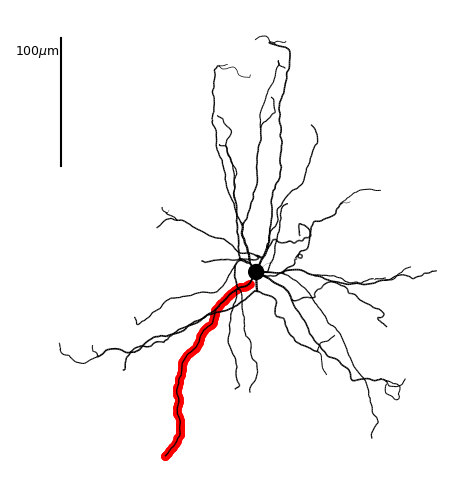

In [38]:
fig, ax = plt.subplots(1, figsize=(4,4))

def find_cover_paths_indices(path, cell):
    
    indices = []
    for i in path:
        indices.append(np.argmin((1e6*cell.SEGMENTS['x']-1e-3*cell.skeleton.vertices[i,0])**2+\
                                 (1e6*cell.SEGMENTS['y']-1e-3*cell.skeleton.vertices[i,1])**2+\
                                 (1e6*cell.SEGMENTS['z']-1e-3*cell.skeleton.vertices[i,2])**2))
    return np.unique(indices)

def list_synapses_on_branch(branch_indices, cell):
    
    List = []
    for syn in cell.synapses_morpho_index:
        if syn in branch_indices:
            List.append(syn)
    return np.array(List)
    

vis = nrnvyz(cell.SEGMENTS)
vis.plot_segments(cond=(cell.SEGMENTS['comp_type']!='axon'),
                  bar_scale_args={'Ybar':100, 'Xbar':1e-9,
                                  'Ybar_label':'100$\mu$m ', 'fontsize':6}, ax=ax)

index = 14
path = np.array(cell.dend_cover_paths[index])
#path = np.concatenate([np.array(cell.dend_cover_paths[6]),
#                       np.array(cell.dend_cover_paths[5])])
#path = np.concatenate([np.array(cell.dend_cover_paths[0]),
#                       np.array(cell.dend_cover_paths[5])])

ax.scatter(1e-3*cell.skeleton.vertices[path,0],
           1e-3*cell.skeleton.vertices[path,1],
           color='r', s=10, alpha=1)

path = find_cover_paths_indices(path, cell)
ax.scatter(1e6*cell.SEGMENTS['x'][path], 1e6*cell.SEGMENTS['y'][path],
           s = 10,
           color='r', alpha=1)

#vis.add_dots(ax,
#             range(len(cell.SEGMENTS['x'])), cell.SEGMENTS['Nsyn']/5)

## Showing the different branches

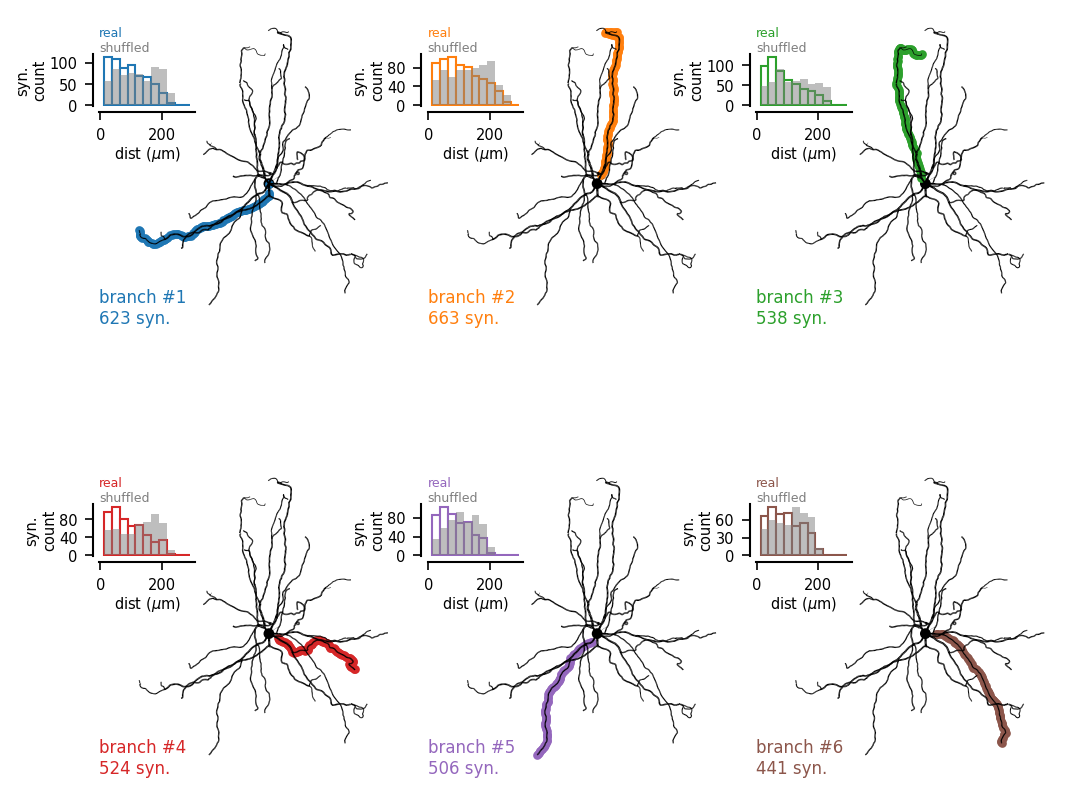

In [42]:
PATHS = [np.concatenate([np.array(cell.dend_cover_paths[0]),
                         np.array(cell.dend_cover_paths[5])]),
         np.array(cell.dend_cover_paths[1]),
         np.array(cell.dend_cover_paths[3]),
         np.array(cell.dend_cover_paths[6]),
         np.array(cell.dend_cover_paths[14]),
         np.array(cell.dend_cover_paths[12])]


SYNAPSES = []
for a, path in enumerate(PATHS):
    branch_indices = find_cover_paths_indices(path, cell)
    SYNAPSES.append(list_synapses_on_branch(branch_indices, cell))


def create_branches_fig(cell, PATHS, SYNAPSES,
                        bins = np.linspace(0, 280, 12)):
    
    fig, AX = plt.subplots(int(len(PATHS)/3), 3, figsize=(8,6))
    plt.subplots_adjust(hspace=0, bottom=0, top=1)

    np.random.seed(2)

    for a, path, synapses in zip(range(len(PATHS)), PATHS, SYNAPSES):

        color = plt.cm.tab10(a)

        vis = nrnvyz(cell.SEGMENTS)
        vis.plot_segments(cond=(cell.SEGMENTS['comp_type']!='axon'),
                          bar_scale_args={'Ybar':1e-9, 'Xbar':1e-9},
                          ax=AX[int(a/3), a%3])

        branch_indices = find_cover_paths_indices(path, cell)
        AX[int(a/3), a%3].scatter(1e6*cell.SEGMENTS['x'][branch_indices],
                                  1e6*cell.SEGMENTS['y'][branch_indices],
                                  s=10, color=color, alpha=1)

        inset = pt.inset(AX[int(a/3), a%3], [-0.1, 0.7, .35, .17])

        hist, be = np.histogram(1e6*cell.SEGMENTS['distance_to_soma'][synapses], bins=bins)
        inset.bar(be[1:], hist, width=be[1]-be[0], edgecolor=color, color='w')

        shuffled = np.random.choice(branch_indices, len(synapses))
        hist, be = np.histogram(1e6*cell.SEGMENTS['distance_to_soma'][shuffled], bins=bins)
        inset.bar(be[1:], hist, width=be[1]-be[0], alpha=.5, color='tab:grey')

        pt.set_plot(inset, xticks=[0,200],
                    ylabel='syn.\ncount', xlabel='dist ($\mu$m)', fontsize=7)
        pt.annotate(AX[int(a/3), a%3],
                    'branch #%i\n%i syn.' % (a+1, len(synapses)), (-0.1,0.1), 
                    color=color, va='top')
        pt.annotate(inset, 'real\n', (0,1), color=color, fontsize=6)
        pt.annotate(inset, 'shuffled', (0,1), color='tab:grey', fontsize=6)

    for ax in pt.flatten(AX):
        ax.axis('off')
        
    return fig
    
fig = create_branches_fig(cell, PATHS, SYNAPSES)

save_dendritic_path(ID, PATHS, SYNAPSES)
    
fig.savefig('../figures/BC-dendritic-branches.svg')

In [ ]:
# check shuffling on the whole morphology
np.random.seed(2)

all_segs = np.arange(len(cell.SEGMENTS['x']))[cell.SEGMENTS['comp_type']!='axon']
density = cell.SEGMENTS['area'][cell.SEGMENTS['comp_type']!='axon']
uniform_pick = np.random.choice(all_segs, len(cell.synapses_morpho_index))
                                #p=density/np.sum(density))
plt.hist(1e6*cell.SEGMENTS['distance_to_soma'][uniform_pick],
         bins=np.linspace(0,250), color='tab:grey', alpha=.5)
plt.hist(1e6*cell.SEGMENTS['distance_to_soma'][cell.synapses_morpho_index], 
         bins=np.linspace(0,250), color='r', alpha=.5);

In [ ]:
# morphology with axon
fig, ax = plt.subplots(1, figsize=(4,4))

index = 2

vis = nrnvyz(cell.SEGMENTS)
vis.plot_segments(#cond=(cell.SEGMENTS['comp_type']!='axon'),
                  bar_scale_args={'Ybar':100, 'Xbar':1e-9,
                                  'Ybar_label':'100$\mu$m ', 'fontsize':6}, ax=ax)

# Martinotti Cell

In [43]:
# Martinotti Cell
ID = '864691135571546917_264824' # load('864691137053906294_301107')
cell = load(ID)

In [ ]:
fig, ax = plt.subplots(1, figsize=(8,6))
plt.subplots_adjust(bottom=0, right=1)

vis = nrnvyz(cell.SEGMENTS)
vis.plot_segments(cond=(cell.SEGMENTS['comp_type']!='axon'),
                  bar_scale_args={'Ybar':100, 'Xbar':1e-9,
                                  'Ybar_label':'100$\mu$m ', 'fontsize':6}, ax=ax)
ax.scatter(1e6*cell.SEGMENTS['x'][cell.synapses_morpho_index][::10],
           1e6*cell.SEGMENTS['y'][cell.synapses_morpho_index][::10],
           color='r', s=1, alpha=1)
ax.scatter(1e6*cell.SEGMENTS['x'], 1e6*cell.SEGMENTS['y'],
           s = .2*cell.SEGMENTS['Nsyn'],
           color='r', alpha=1)

#vis.add_dots(ax, range(len(cell.SEGMENTS['x'])), cell.SEGMENTS['Nsyn']/5)

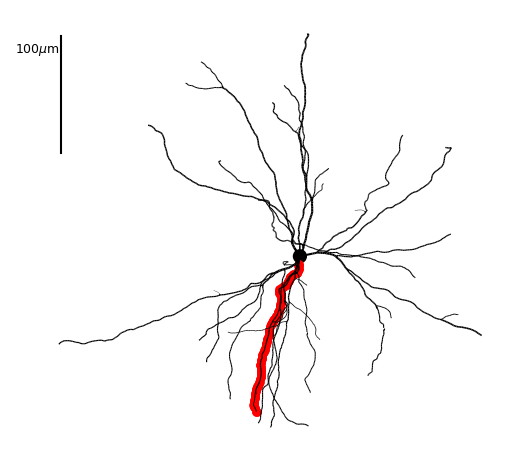

In [65]:
fig, ax = plt.subplots(1, figsize=(4,4))

vis = nrnvyz(cell.SEGMENTS)
vis.plot_segments(cond=(cell.SEGMENTS['comp_type']!='axon'),
                  bar_scale_args={'Ybar':100, 'Xbar':1e-9,
                                  'Ybar_label':'100$\mu$m ', 'fontsize':6}, ax=ax)

index = 9
path = np.array(cell.dend_cover_paths[index])

ax.scatter(1e-3*cell.skeleton.vertices[path,0],
           1e-3*cell.skeleton.vertices[path,1],
           color='r', s=10, alpha=1)

path = find_cover_paths_indices(path, cell)
ax.scatter(1e6*cell.SEGMENTS['x'][path], 1e6*cell.SEGMENTS['y'][path],
           s = 10,
           color='r', alpha=1)

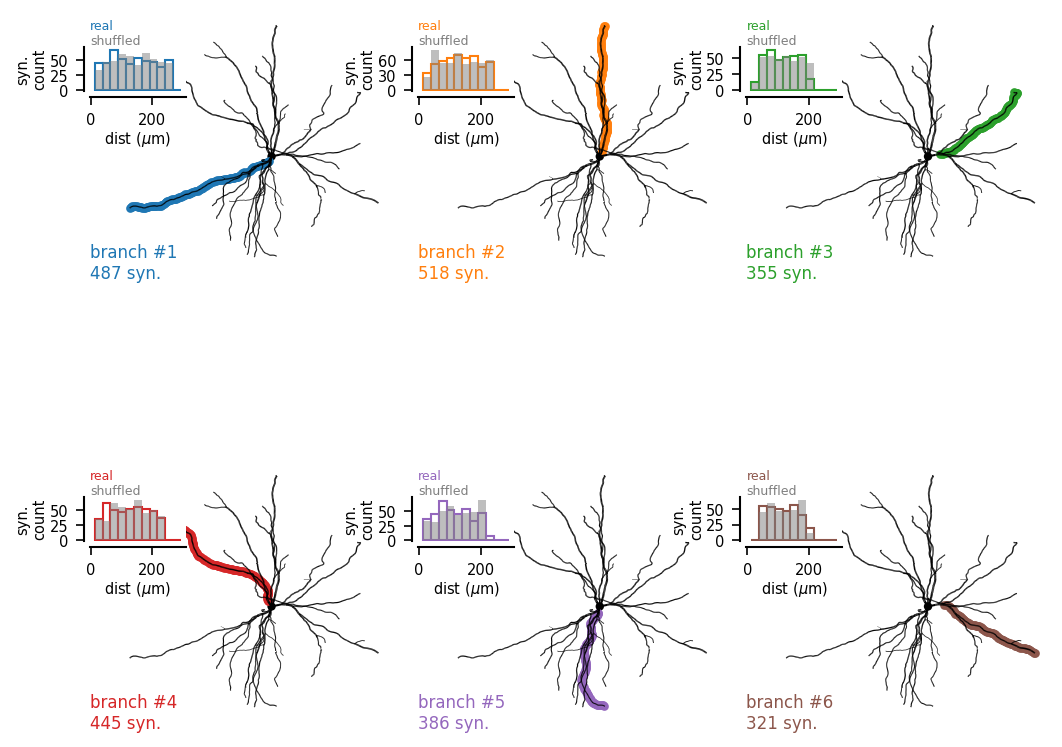

In [64]:
PATHS = [np.array(cell.dend_cover_paths[1]),
         np.array(cell.dend_cover_paths[2]),
         np.array(cell.dend_cover_paths[8]),
         np.array(cell.dend_cover_paths[4]),
         np.array(cell.dend_cover_paths[7]),
         np.array(cell.dend_cover_paths[10])]

SYNAPSES = []
for a, path in enumerate(PATHS):
    branch_indices = find_cover_paths_indices(path, cell)
    SYNAPSES.append(list_synapses_on_branch(branch_indices, cell))

fig = create_branches_fig(cell, PATHS, SYNAPSES)

save_dendritic_path(ID, PATHS, SYNAPSES)
    
fig.savefig('../figures/MC-dendritic-branches.svg')